In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

#LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

#PCA
from sklearn.decomposition import PCA

#Seaborn
import seaborn as sns


In [2]:
import psycopg2
import os
from dotenv import load_dotenv
load_dotenv()

try:
    conn = psycopg2.connect(
        dbname=os.getenv('dbname'),
        user=os.getenv('user'),
        password=os.getenv('password'),
        host=os.getenv('host'),
        port=os.getenv('port')
    )
    print("Connection OK\n")
except Exception as e:
    print("Error:", e)

query = "SELECT * FROM combined_indicators;"
df_all = pd.read_sql(query, conn)
df_all['ind_code'] = df_all['ind_code'].str.strip()

df = df_all.pivot_table(
    index='date_month',
    columns='ind_code',
    values='value'
).reset_index()

df['date_month'] = pd.to_datetime(df['date_month'])
df = df.set_index('date_month')
df = df.asfreq('MS')

test_size = 18
train_data = df[:-test_size]
test_data = df[-test_size:]

print("Train:", train_data.shape)
print("Test :", test_data.shape)


Connection OK



C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\2982564361.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_all = pd.read_sql(query, conn)


Train: (204, 10)
Test : (18, 10)


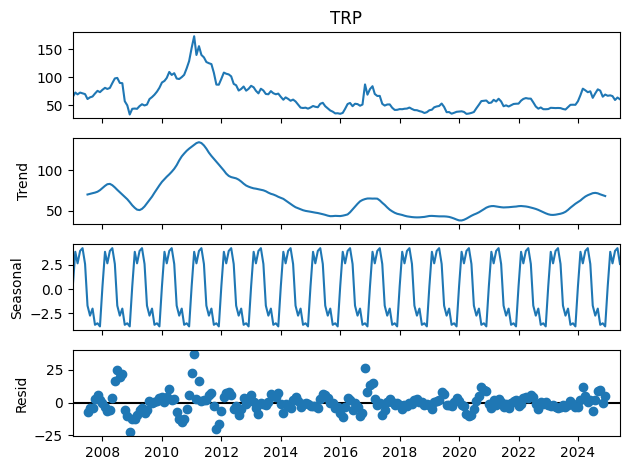

In [3]:
result = seasonal_decompose(df['TRP'], model='additive', period=12)
result.plot()
plt.show()

Available columns: ['EXR', 'OILP', 'PMI', 'TDC', 'TRI', 'TRP', 'TRPD', 'TRS', 'TRX', 'WRP']
Selected external factors: ['EXR', 'OILP', 'PMI', 'TDC', 'TRI', 'TRPD', 'TRS', 'TRX', 'WRP']

Mean TRP (train): 64.5769
X_train: (204, 9)  X_test: (18, 9)


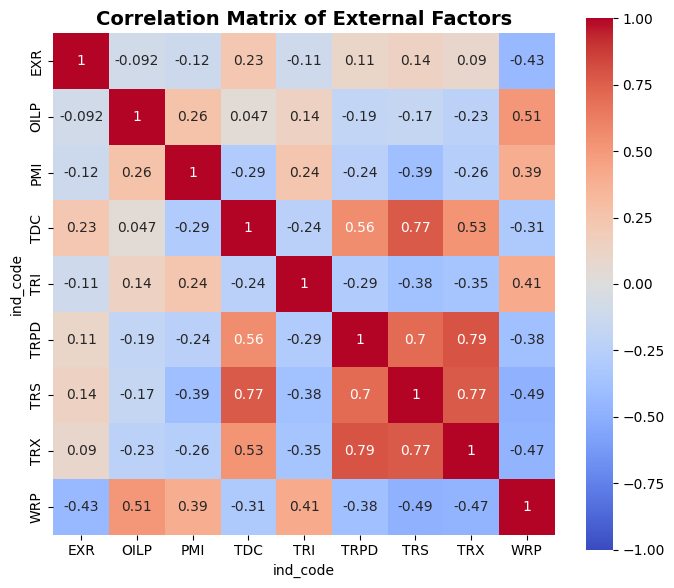

In [4]:
external_factors = ['EXR', 'OILP', 'PMI','TDC', 'TRI', 'TRPD','TRS', 'TRX', 'WRP']

print("Available columns:", df.columns.tolist())
print("Selected external factors:", [c for c in external_factors if c in df.columns])
print()

#เตรียม X, y
train_exog = train_data[external_factors].copy()
test_exog  = test_data[external_factors].copy()

X_train_raw = train_exog.copy()
X_test_raw  = test_exog.copy()
y_train = train_data['TRP']
y_test  = test_data['TRP']

mean_trp = y_train.mean()
print(f"Mean TRP (train): {mean_trp:.4f}")
print("X_train:", X_train_raw.shape, " X_test:", X_test_raw.shape)

# Scaling (ใช้กับทุกโมเดล Ridge)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test  = scaler.transform(X_test_raw)

# Correlation matrix ของ external factors
corr = train_exog.corr()

plt.figure(figsize=(7, 6))
sns.heatmap(
    corr,
    annot=True,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    square=True
)
plt.title("Correlation Matrix of External Factors", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [5]:
full_train = train_data[['TRP'] + external_factors].copy()
full_test  = test_data[['TRP'] + external_factors].copy()

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(full_train)
test_scaled  = scaler.transform(full_test)

WINDOW = 12

def create_seq(data, win=WINDOW):
    X, y = [], []
    for i in range(len(data)-win):
        X.append(data[i:i+win, :])
        y.append(data[i+win, 0])
    return np.array(X), np.array(y)


X_train, y_train = create_seq(train_scaled)
X_test, y_test   = create_seq(test_scaled)

print("X_train:", X_train.shape)
print("X_test :", X_test.shape)


X_train: (192, 12, 10)
X_test : (6, 12, 10)


In [6]:
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=False,
         input_shape=(WINDOW, X_train.shape[2])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,313 (83.25 KB)

 Trainable params: 21,313 (83.25 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=16,
    callbacks=[es],
    verbose=1
)


Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0486 - val_loss: 0.0020
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0132 - val_loss: 0.0044
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0142 - val_loss: 9.1825e-04
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0085 - val_loss: 0.0043
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0091 - val_loss: 9.7061e-04
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0103 - val_loss: 0.0011
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0092 - val_loss: 0.0013
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0087 - val_loss: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0079 - val_loss: 0.0015
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0074 - val_loss: 7.7947e-04
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0067 - val_loss: 6.2906e-04
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━

In [8]:
pred_scaled = model.predict(X_test)

dummy = np.zeros((len(pred_scaled), train_scaled.shape[1]))
dummy[:,0] = pred_scaled[:,0]

pred = scaler.inverse_transform(dummy)[:,0]
actual = test_data['TRP'].iloc[WINDOW:].values

rmse_before = np.sqrt(mean_squared_error(actual, pred))
mape_before = mean_absolute_percentage_error(actual, pred)*100

print("=== BEFORE MODEL (Baseline LSTM) ===")
print(f"RMSE : {rmse_before:.4f}")
print(f"MAPE : {mape_before:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
=== BEFORE MODEL (Baseline LSTM) ===
RMSE : 9.4288
MAPE : 13.48%


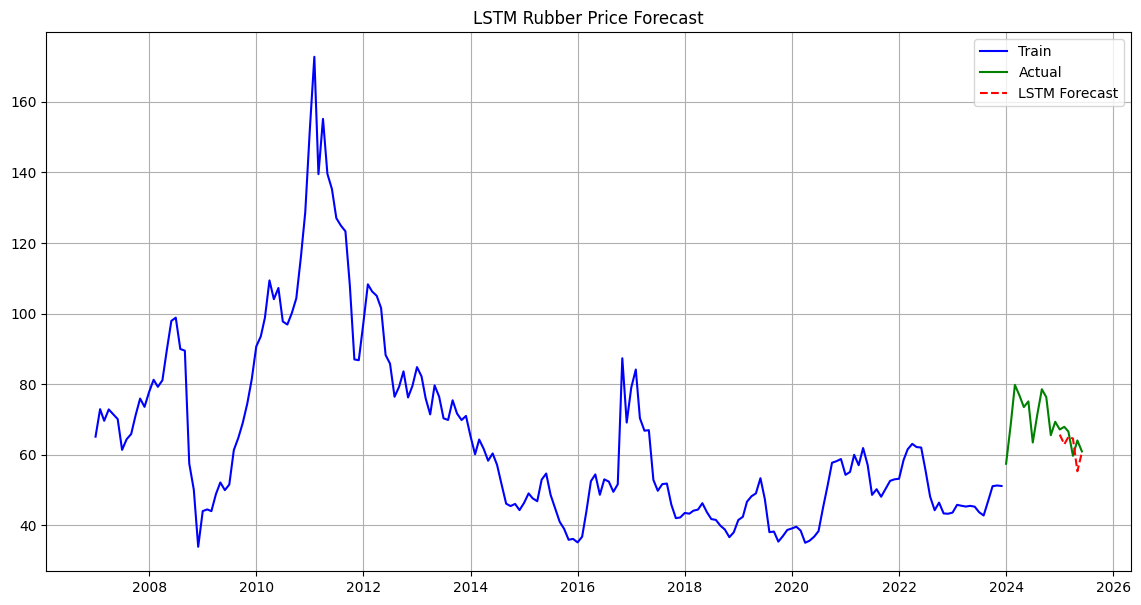

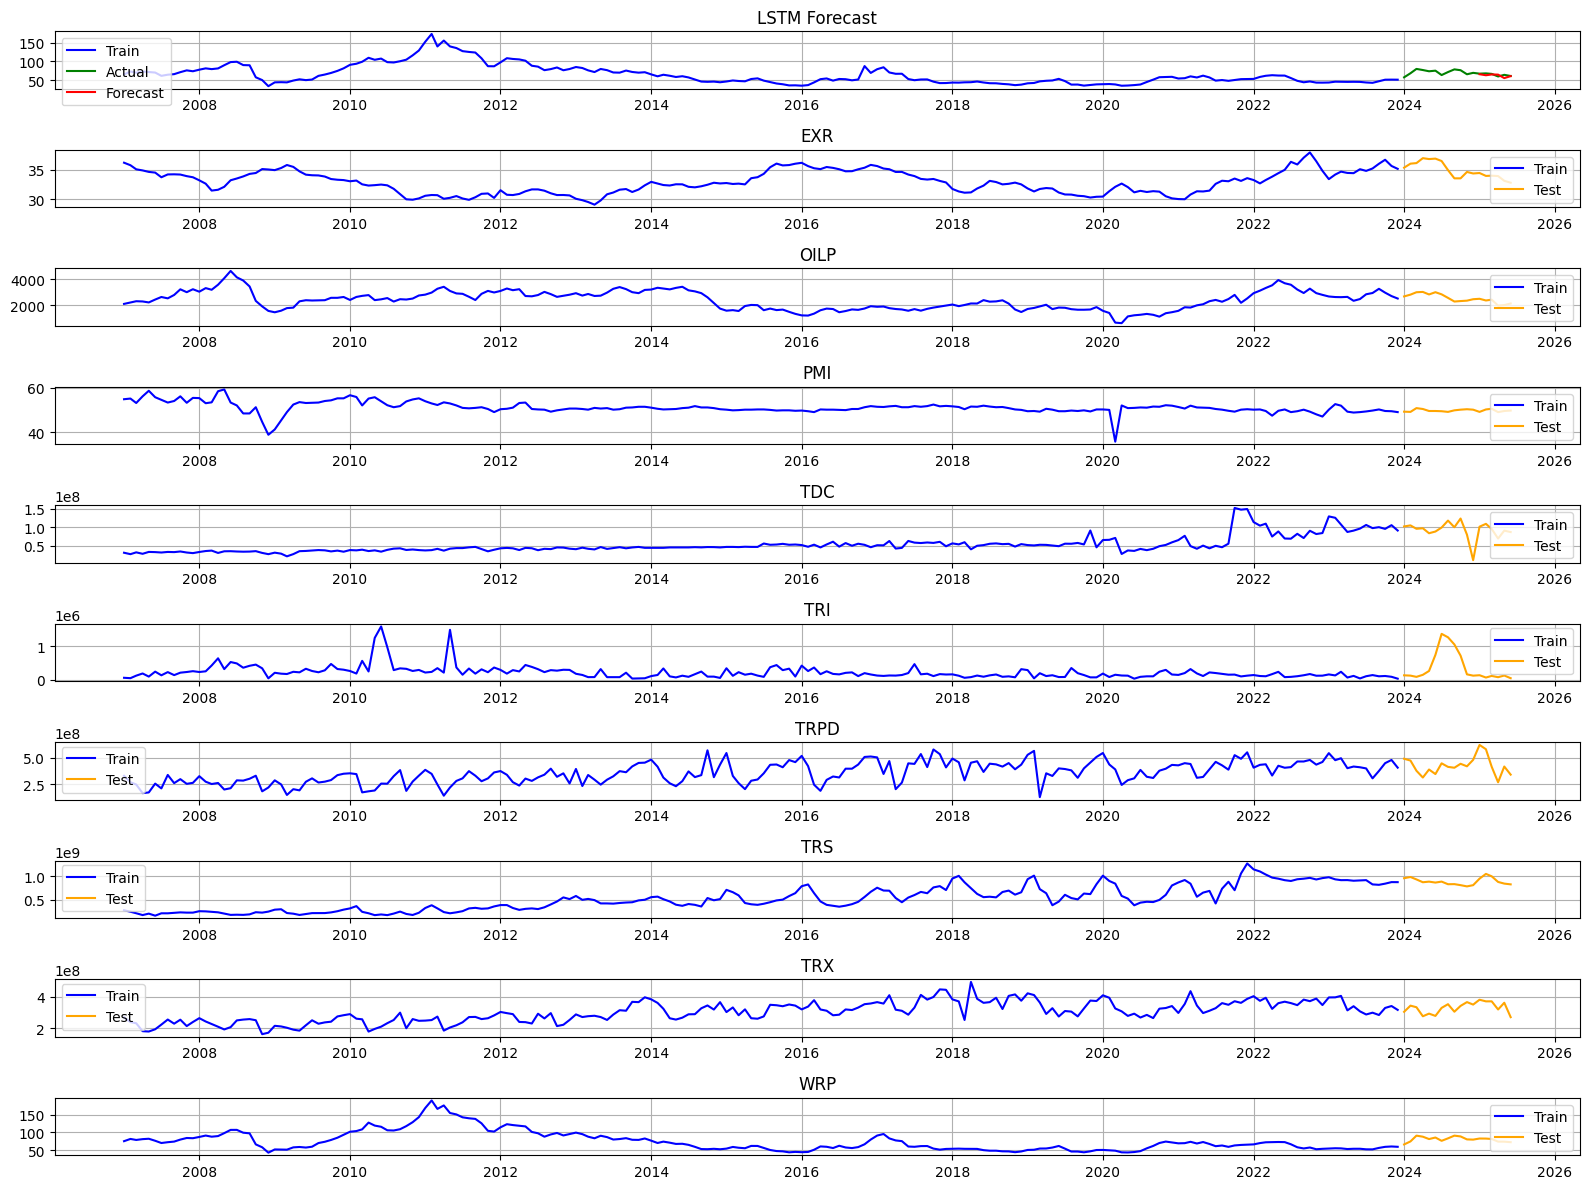

In [ ]:
pred_index = test_data.index[-len(pred):]

plt.figure(figsize=(14,7))
plt.plot(train_data.index, train_data['TRP'], label='Train', color='blue')

plt.plot(test_data.index, actual, label='Actual', color='green')

plt.plot(pred_index, pred, label='LSTM Forecast', color='red', linestyle='--')

plt.title("LSTM Rubber Price Forecast")
plt.grid(True)
plt.legend()
plt.show()


fig, axes = plt.subplots(len(external_factors)+1, 1, figsize=(16,12))

axes[0].plot(train_data.index, train_data['TRP'], label='Train', color='blue')

axes[0].plot(test_data.index, actual, color='green', label='Actual')
axes[0].plot(pred_index, pred, color='red', label='Forecast')
axes[0].legend()
axes[0].set_title("LSTM Forecast")
axes[0].grid(True)

for i, fac in enumerate(external_factors):
    ax = axes[i+1]
    ax.plot(train_data.index, train_data[fac], color='blue', label='Train')
    ax.plot(test_data.index, test_data[fac], color='orange', label='Test')
    ax.set_title(fac)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


Parameter Optimization (Optuna)

In [11]:
import optuna

def objective_lstm(trial):
    lstm_units = trial.suggest_int('lstm_units', 32, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    dense_units = trial.suggest_int('dense_units', 16, 64)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)

    model = Sequential([
        LSTM(lstm_units, 
             activation='tanh', 
             return_sequences=False,
             input_shape=(WINDOW, X_train.shape[2])
            ),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu'),
        Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')

    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=100,
        batch_size=16,
        callbacks=[es],
        verbose=0
    )

    pred_scaled = model.predict(X_test)
    dummy = np.zeros((len(pred_scaled), train_scaled.shape[1]))
    dummy[:,0] = pred_scaled[:,0]
    pred = scaler.inverse_transform(dummy)[:,0]
    actual = test_data['TRP'].iloc[WINDOW:].values

    rmse = np.sqrt(mean_squared_error(actual, pred))
    return rmse


study_lstm = optuna.create_study(direction='minimize')
study_lstm.optimize(objective_lstm, n_trials=60)

best_lstm_params = study_lstm.best_params
print("\n=== OPTUNA BEST PARAMS (LSTM) ===")
print(best_lstm_params)

c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-11-26 00:43:26,758] A new study created in memory with name: no-name-ae80b158-ad36-470d-ae46-fa9768e8a4e0
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first la

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


[I 2025-11-26 00:43:31,400] Trial 0 finished with value: 3.916683733571012 and parameters: {'lstm_units': 108, 'dropout_rate': 0.45627842226365267, 'dense_units': 34, 'learning_rate': 0.003300822356679555}. Best is trial 0 with value: 3.916683733571012.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


[I 2025-11-26 00:43:37,558] Trial 1 finished with value: 4.05794315079796 and parameters: {'lstm_units': 116, 'dropout_rate': 0.3515552500993223, 'dense_units': 46, 'learning_rate': 0.0001629615261598504}. Best is trial 0 with value: 3.916683733571012.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


[I 2025-11-26 00:43:44,925] Trial 2 finished with value: 6.062167829009466 and parameters: {'lstm_units': 75, 'dropout_rate': 0.10682286618003466, 'dense_units': 59, 'learning_rate': 0.005315157886867143}. Best is trial 0 with value: 3.916683733571012.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


[I 2025-11-26 00:43:51,474] Trial 3 finished with value: 5.511311236361202 and parameters: {'lstm_units': 113, 'dropout_rate': 0.428163126254162, 'dense_units': 44, 'learning_rate': 0.0024202924440669005}. Best is trial 0 with value: 3.916683733571012.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


[I 2025-11-26 00:43:56,270] Trial 4 finished with value: 5.866827176462243 and parameters: {'lstm_units': 49, 'dropout_rate': 0.49579338584973554, 'dense_units': 51, 'learning_rate': 0.0006384711906220853}. Best is trial 0 with value: 3.916683733571012.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2025-11-26 00:44:03,259] Trial 5 finished with value: 3.344120624792107 and parameters: {'lstm_units': 115, 'dropout_rate': 0.2505854772378042, 'dense_units': 33, 'learning_rate': 0.0023736705237482917}. Best is trial 5 with value: 3.344120624792107.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


[I 2025-11-26 00:44:07,645] Trial 6 finished with value: 5.665604032422575 and parameters: {'lstm_units': 58, 'dropout_rate': 0.3012437796544166, 'dense_units': 62, 'learning_rate': 0.0015898578661727196}. Best is trial 5 with value: 3.344120624792107.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


[I 2025-11-26 00:44:13,867] Trial 7 finished with value: 9.176239344067843 and parameters: {'lstm_units': 115, 'dropout_rate': 0.30906392790656767, 'dense_units': 25, 'learning_rate': 0.0011763291373613194}. Best is trial 5 with value: 3.344120624792107.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


[I 2025-11-26 00:44:17,349] Trial 8 finished with value: 15.053389230355307 and parameters: {'lstm_units': 37, 'dropout_rate': 0.2751747549146689, 'dense_units': 40, 'learning_rate': 0.00013541650044309416}. Best is trial 5 with value: 3.344120624792107.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


[I 2025-11-26 00:44:22,072] Trial 9 finished with value: 2.622621652770422 and parameters: {'lstm_units': 55, 'dropout_rate': 0.2544815470098816, 'dense_units': 55, 'learning_rate': 0.0015787108819365345}. Best is trial 9 with value: 2.622621652770422.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2025-11-26 00:44:28,883] Trial 10 finished with value: 6.672056901620287 and parameters: {'lstm_units': 85, 'dropout_rate': 0.17082911600602474, 'dense_units': 54, 'learning_rate': 0.009469429828139477}. Best is trial 9 with value: 2.622621652770422.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


[I 2025-11-26 00:44:37,392] Trial 11 finished with value: 9.606209873224321 and parameters: {'lstm_units': 86, 'dropout_rate': 0.20810348886045177, 'dense_units': 19, 'learning_rate': 0.0005445092074525203}. Best is trial 9 with value: 2.622621652770422.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


[I 2025-11-26 00:44:45,093] Trial 12 finished with value: 6.296458973562369 and parameters: {'lstm_units': 67, 'dropout_rate': 0.22494759858478136, 'dense_units': 31, 'learning_rate': 0.0004605640933095741}. Best is trial 9 with value: 2.622621652770422.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


[I 2025-11-26 00:44:50,315] Trial 13 finished with value: 3.5319073972076667 and parameters: {'lstm_units': 95, 'dropout_rate': 0.36702637915479697, 'dense_units': 35, 'learning_rate': 0.0028406237185963257}. Best is trial 9 with value: 2.622621652770422.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


[I 2025-11-26 00:44:57,105] Trial 14 finished with value: 3.670213988048163 and parameters: {'lstm_units': 126, 'dropout_rate': 0.2344643394799169, 'dense_units': 27, 'learning_rate': 0.0012300032086438144}. Best is trial 9 with value: 2.622621652770422.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


[I 2025-11-26 00:45:00,904] Trial 15 finished with value: 9.752964169000098 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1537637269678125, 'dense_units': 40, 'learning_rate': 0.00028640099748314634}. Best is trial 9 with value: 2.622621652770422.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


[I 2025-11-26 00:45:06,089] Trial 16 finished with value: 3.4955005429154595 and parameters: {'lstm_units': 98, 'dropout_rate': 0.2602531626638481, 'dense_units': 16, 'learning_rate': 0.00569674761867829}. Best is trial 9 with value: 2.622621652770422.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


[I 2025-11-26 00:45:13,073] Trial 17 finished with value: 11.285657244446607 and parameters: {'lstm_units': 49, 'dropout_rate': 0.34520278942141336, 'dense_units': 54, 'learning_rate': 0.001809543896135153}. Best is trial 9 with value: 2.622621652770422.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2025-11-26 00:45:22,928] Trial 18 finished with value: 13.251996439166962 and parameters: {'lstm_units': 71, 'dropout_rate': 0.1718552671572513, 'dense_units': 48, 'learning_rate': 0.0008363509021261505}. Best is trial 9 with value: 2.622621652770422.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


[I 2025-11-26 00:45:26,858] Trial 19 finished with value: 6.7502341476355 and parameters: {'lstm_units': 62, 'dropout_rate': 0.1044664316242073, 'dense_units': 64, 'learning_rate': 0.0045658118258861385}. Best is trial 9 with value: 2.622621652770422.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


[I 2025-11-26 00:45:31,850] Trial 20 finished with value: 3.4787389594974685 and parameters: {'lstm_units': 49, 'dropout_rate': 0.40595626590003125, 'dense_units': 23, 'learning_rate': 0.009926474066811294}. Best is trial 9 with value: 2.622621652770422.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


[I 2025-11-26 00:45:36,696] Trial 21 finished with value: 3.15234822628857 and parameters: {'lstm_units': 49, 'dropout_rate': 0.407597525918276, 'dense_units': 23, 'learning_rate': 0.009966204400096237}. Best is trial 9 with value: 2.622621652770422.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


[I 2025-11-26 00:45:42,612] Trial 22 finished with value: 10.453467840023018 and parameters: {'lstm_units': 41, 'dropout_rate': 0.3225349667573493, 'dense_units': 30, 'learning_rate': 0.001883186225173627}. Best is trial 9 with value: 2.622621652770422.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


[I 2025-11-26 00:45:47,472] Trial 23 finished with value: 5.406096206449225 and parameters: {'lstm_units': 60, 'dropout_rate': 0.2761717803321172, 'dense_units': 38, 'learning_rate': 0.0038390855093077855}. Best is trial 9 with value: 2.622621652770422.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


[I 2025-11-26 00:45:54,817] Trial 24 finished with value: 4.8461245914874755 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3781731095812946, 'dense_units': 21, 'learning_rate': 0.006412190247876985}. Best is trial 9 with value: 2.622621652770422.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


[I 2025-11-26 00:45:58,457] Trial 25 finished with value: 15.756995969419071 and parameters: {'lstm_units': 53, 'dropout_rate': 0.25176908901662787, 'dense_units': 29, 'learning_rate': 0.00030374773869135623}. Best is trial 9 with value: 2.622621652770422.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2025-11-26 00:46:02,402] Trial 26 finished with value: 2.3498098820221123 and parameters: {'lstm_units': 78, 'dropout_rate': 0.2037288451105448, 'dense_units': 43, 'learning_rate': 0.0024769908970259037}. Best is trial 26 with value: 2.3498098820221123.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2025-11-26 00:46:06,896] Trial 27 finished with value: 6.563400956543896 and parameters: {'lstm_units': 76, 'dropout_rate': 0.21602714718400073, 'dense_units': 58, 'learning_rate': 0.0008820408968808665}. Best is trial 26 with value: 2.3498098820221123.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2025-11-26 00:46:11,153] Trial 28 finished with value: 3.8229381313115365 and parameters: {'lstm_units': 43, 'dropout_rate': 0.18429600310045643, 'dense_units': 45, 'learning_rate': 0.007181478309357785}. Best is trial 26 with value: 2.3498098820221123.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


[I 2025-11-26 00:46:17,527] Trial 29 finished with value: 14.028282809917059 and parameters: {'lstm_units': 65, 'dropout_rate': 0.46801630934252747, 'dense_units': 50, 'learning_rate': 0.0035078138259294423}. Best is trial 26 with value: 2.3498098820221123.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


[I 2025-11-26 00:46:22,471] Trial 30 finished with value: 3.742731198245825 and parameters: {'lstm_units': 82, 'dropout_rate': 0.13213844032699468, 'dense_units': 41, 'learning_rate': 0.0012276436774328937}. Best is trial 26 with value: 2.3498098820221123.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


[I 2025-11-26 00:46:27,461] Trial 31 finished with value: 3.8300741864952235 and parameters: {'lstm_units': 97, 'dropout_rate': 0.19849368579634044, 'dense_units': 32, 'learning_rate': 0.0022921322800818753}. Best is trial 26 with value: 2.3498098820221123.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


[I 2025-11-26 00:46:34,028] Trial 32 finished with value: 3.045189670519105 and parameters: {'lstm_units': 105, 'dropout_rate': 0.24473920861759768, 'dense_units': 36, 'learning_rate': 0.0028884272431842313}. Best is trial 26 with value: 2.3498098820221123.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


[I 2025-11-26 00:46:39,988] Trial 33 finished with value: 11.00928753066722 and parameters: {'lstm_units': 91, 'dropout_rate': 0.28480423012165146, 'dense_units': 43, 'learning_rate': 0.0037099992803302385}. Best is trial 26 with value: 2.3498098820221123.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


[I 2025-11-26 00:46:47,144] Trial 34 finished with value: 4.154046503732571 and parameters: {'lstm_units': 106, 'dropout_rate': 0.3283664635793077, 'dense_units': 36, 'learning_rate': 0.001621594360171188}. Best is trial 26 with value: 2.3498098820221123.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


[I 2025-11-26 00:46:53,607] Trial 35 finished with value: 7.3419278545945525 and parameters: {'lstm_units': 56, 'dropout_rate': 0.4362431529050823, 'dense_units': 58, 'learning_rate': 0.0029234715032482278}. Best is trial 26 with value: 2.3498098820221123.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


[I 2025-11-26 00:46:57,872] Trial 36 finished with value: 3.0220925189229186 and parameters: {'lstm_units': 106, 'dropout_rate': 0.14275521610872707, 'dense_units': 47, 'learning_rate': 0.004271858980351029}. Best is trial 26 with value: 2.3498098820221123.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


[I 2025-11-26 00:47:02,503] Trial 37 finished with value: 7.251169504733643 and parameters: {'lstm_units': 106, 'dropout_rate': 0.14022817131215237, 'dense_units': 47, 'learning_rate': 0.004257223831366789}. Best is trial 26 with value: 2.3498098820221123.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


[I 2025-11-26 00:47:06,660] Trial 38 finished with value: 8.874401791406191 and parameters: {'lstm_units': 108, 'dropout_rate': 0.2390994593737188, 'dense_units': 55, 'learning_rate': 0.0021703386417502506}. Best is trial 26 with value: 2.3498098820221123.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2025-11-26 00:47:12,173] Trial 39 finished with value: 5.151647531341309 and parameters: {'lstm_units': 123, 'dropout_rate': 0.12894252381832483, 'dense_units': 51, 'learning_rate': 0.002896561784295249}. Best is trial 26 with value: 2.3498098820221123.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2025-11-26 00:47:20,119] Trial 40 finished with value: 9.63234533726497 and parameters: {'lstm_units': 121, 'dropout_rate': 0.1891993744491307, 'dense_units': 42, 'learning_rate': 0.0014740046349145523}. Best is trial 26 with value: 2.3498098820221123.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2025-11-26 00:47:26,169] Trial 41 finished with value: 4.145125568126495 and parameters: {'lstm_units': 100, 'dropout_rate': 0.16503044275502202, 'dense_units': 37, 'learning_rate': 0.007576700155889475}. Best is trial 26 with value: 2.3498098820221123.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


[I 2025-11-26 00:47:31,262] Trial 42 finished with value: 4.680203869959538 and parameters: {'lstm_units': 76, 'dropout_rate': 0.26463201890990706, 'dense_units': 48, 'learning_rate': 0.005179283708994047}. Best is trial 26 with value: 2.3498098820221123.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


[I 2025-11-26 00:47:37,779] Trial 43 finished with value: 3.0294555638846714 and parameters: {'lstm_units': 112, 'dropout_rate': 0.21051443280174964, 'dense_units': 51, 'learning_rate': 0.008264541705904894}. Best is trial 26 with value: 2.3498098820221123.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


[I 2025-11-26 00:47:44,388] Trial 44 finished with value: 6.1524113148215465 and parameters: {'lstm_units': 112, 'dropout_rate': 0.21411844879564942, 'dense_units': 51, 'learning_rate': 0.004584527758204843}. Best is trial 26 with value: 2.3498098820221123.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


[I 2025-11-26 00:47:49,805] Trial 45 finished with value: 2.896047592517263 and parameters: {'lstm_units': 103, 'dropout_rate': 0.294069972365825, 'dense_units': 45, 'learning_rate': 0.008009426528922328}. Best is trial 26 with value: 2.3498098820221123.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


[I 2025-11-26 00:47:54,182] Trial 46 finished with value: 2.8069974958647546 and parameters: {'lstm_units': 91, 'dropout_rate': 0.1992987808580324, 'dense_units': 45, 'learning_rate': 0.0076676160573662805}. Best is trial 26 with value: 2.3498098820221123.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


[I 2025-11-26 00:48:01,710] Trial 47 finished with value: 5.3916703151500345 and parameters: {'lstm_units': 93, 'dropout_rate': 0.3004493933623211, 'dense_units': 45, 'learning_rate': 0.005579378282412232}. Best is trial 26 with value: 2.3498098820221123.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


[I 2025-11-26 00:48:05,007] Trial 48 finished with value: 14.414643721922943 and parameters: {'lstm_units': 90, 'dropout_rate': 0.1453557678073032, 'dense_units': 55, 'learning_rate': 0.00010719053932389419}. Best is trial 26 with value: 2.3498098820221123.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


[I 2025-11-26 00:48:10,361] Trial 49 finished with value: 4.435905879773491 and parameters: {'lstm_units': 86, 'dropout_rate': 0.23129845416929695, 'dense_units': 39, 'learning_rate': 0.007378972112759706}. Best is trial 26 with value: 2.3498098820221123.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


[I 2025-11-26 00:48:14,783] Trial 50 finished with value: 11.903079182336716 and parameters: {'lstm_units': 102, 'dropout_rate': 0.1839379989528097, 'dense_units': 49, 'learning_rate': 0.005804539707550748}. Best is trial 26 with value: 2.3498098820221123.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


[I 2025-11-26 00:48:23,918] Trial 51 finished with value: 4.841888890705737 and parameters: {'lstm_units': 117, 'dropout_rate': 0.20991007694841265, 'dense_units': 46, 'learning_rate': 0.007720026545460791}. Best is trial 26 with value: 2.3498098820221123.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2025-11-26 00:48:30,587] Trial 52 finished with value: 3.244357728646785 and parameters: {'lstm_units': 112, 'dropout_rate': 0.2811932510009553, 'dense_units': 52, 'learning_rate': 0.008459473445673526}. Best is trial 26 with value: 2.3498098820221123.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


[I 2025-11-26 00:48:36,705] Trial 53 finished with value: 3.7275322759663436 and parameters: {'lstm_units': 102, 'dropout_rate': 0.12288631608159613, 'dense_units': 44, 'learning_rate': 0.006355107675748203}. Best is trial 26 with value: 2.3498098820221123.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2025-11-26 00:48:42,475] Trial 54 finished with value: 3.717160487130826 and parameters: {'lstm_units': 119, 'dropout_rate': 0.15970457745208422, 'dense_units': 52, 'learning_rate': 0.004751247527503023}. Best is trial 26 with value: 2.3498098820221123.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


[I 2025-11-26 00:48:49,385] Trial 55 finished with value: 8.393491528873305 and parameters: {'lstm_units': 95, 'dropout_rate': 0.19748016631060264, 'dense_units': 43, 'learning_rate': 0.009069835716767193}. Best is trial 26 with value: 2.3498098820221123.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


[I 2025-11-26 00:48:53,392] Trial 56 finished with value: 2.7273823043167034 and parameters: {'lstm_units': 80, 'dropout_rate': 0.23016992835895908, 'dense_units': 56, 'learning_rate': 0.006309578886629256}. Best is trial 26 with value: 2.3498098820221123.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


[I 2025-11-26 00:48:58,245] Trial 57 finished with value: 3.414530390740958 and parameters: {'lstm_units': 69, 'dropout_rate': 0.2592033871574502, 'dense_units': 62, 'learning_rate': 0.0032888646639678038}. Best is trial 26 with value: 2.3498098820221123.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


[I 2025-11-26 00:49:01,820] Trial 58 finished with value: 6.844915870842386 and parameters: {'lstm_units': 81, 'dropout_rate': 0.22865201550577594, 'dense_units': 60, 'learning_rate': 0.006417467322710827}. Best is trial 26 with value: 2.3498098820221123.
C:\Users\bankw\AppData\Local\Temp\ipykernel_41748\1009454484.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


[I 2025-11-26 00:49:05,211] Trial 59 finished with value: 3.047886996478791 and parameters: {'lstm_units': 72, 'dropout_rate': 0.3154943653342617, 'dense_units': 56, 'learning_rate': 0.0042617479137480405}. Best is trial 26 with value: 2.3498098820221123.



=== OPTUNA BEST PARAMS (LSTM) ===
{'lstm_units': 78, 'dropout_rate': 0.2037288451105448, 'dense_units': 43, 'learning_rate': 0.0024769908970259037}


In [12]:
after_lstm_model = Sequential([
    LSTM(best_lstm_params['lstm_units'], 
            activation='tanh', 
            return_sequences=False,
            input_shape=(WINDOW, X_train.shape[2])
        ),
    Dropout(best_lstm_params['dropout_rate']),
    Dense(best_lstm_params['dense_units'], activation='relu'),
    Dense(1)
])

after_optimiter = tf.keras.optimizers.Adam(learning_rate=best_lstm_params['learning_rate'])
after_es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

after_lstm_model.compile(optimizer=after_optimiter, loss='mse')
after_lstm_model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=200,
    batch_size=16,
    callbacks=[after_es],
    verbose=1
)

pred_scaled_after = after_lstm_model.predict(X_test)
dummy_after = np.zeros((len(pred_scaled_after), train_scaled.shape[1]))
dummy_after[:,0] = pred_scaled_after[:,0]

pred_after = scaler.inverse_transform(dummy_after)[:,0]
actual_after = test_data['TRP'].iloc[WINDOW:].values

rmse_after = np.sqrt(mean_squared_error(actual_after, pred_after))
mape_after = mean_absolute_percentage_error(actual_after, pred_after)*100

print("=== AFTER MODEL (Optuna Tuned LSTM) ===")
print(f"RMSE : {rmse_after:.4f}")
print(f"MAPE : {mape_after:.2f}%")

Epoch 1/200


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - loss: 0.0677 - val_loss: 0.0098
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0112 - val_loss: 0.0017
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0118 - val_loss: 0.0031
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0088 - val_loss: 0.0025
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0066 - val_loss: 0.0038
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0057 - val_loss: 0.0014
Epoch 7/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0074 - val_loss: 0.0053
Epoch 8/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0057 - val_loss: 7.5489e-04
Epoch 9/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0055 - val_loss: 9.6223e-04
Epoch 10/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0054 - val_loss: 0.0029
Epoch 11/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0038 - val_loss: 7.7785e-04
Epoch 12/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/ste

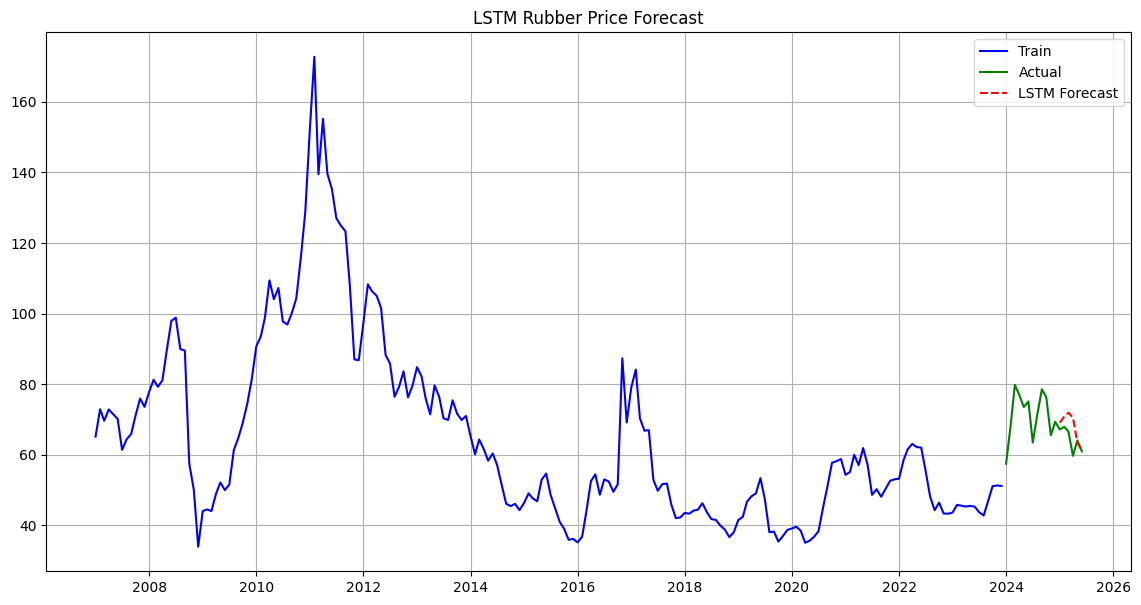

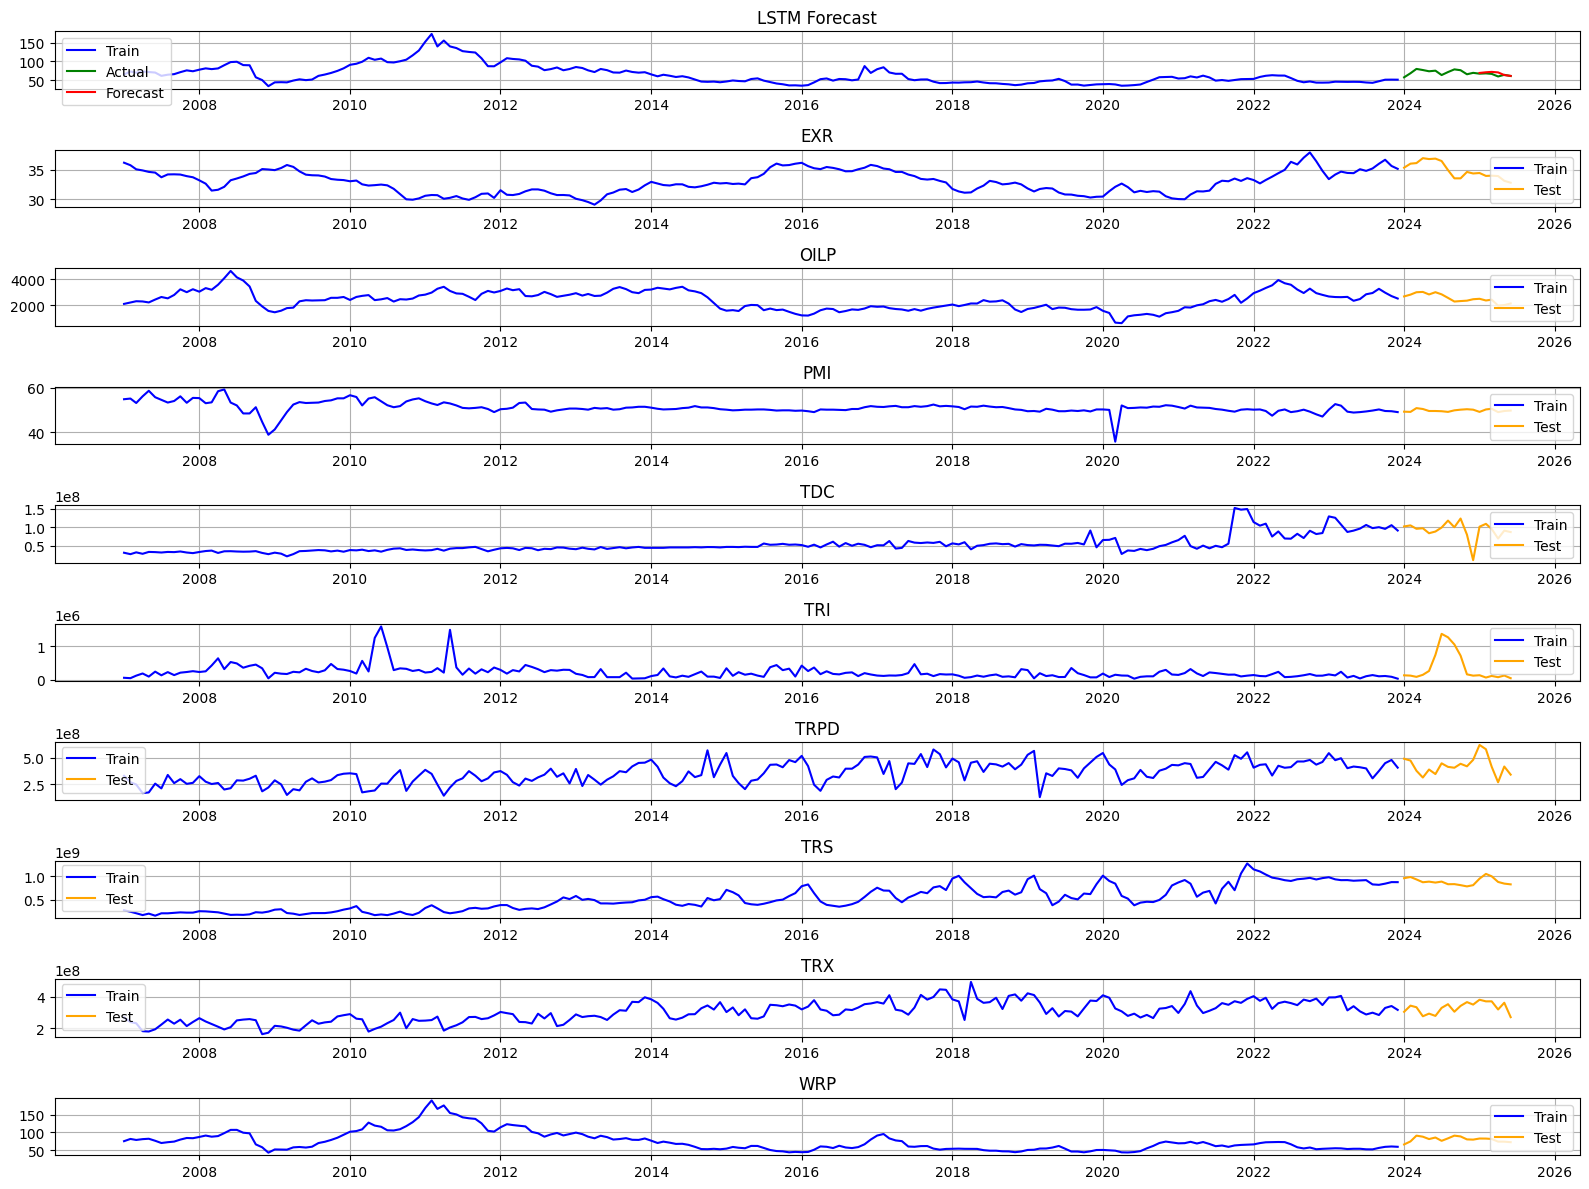

In [ ]:
pred_after_index = test_data.index[-len(pred_after):]
actual_after = test_data['TRP'].values

plt.figure(figsize=(14,7))

plt.plot(train_data.index, train_data['TRP'], label='Train', color='blue')

plt.plot(test_data.index, actual_after, label='Actual', color='green')

plt.plot(pred_after_index, pred_after, label='LSTM Forecast', color='red', linestyle='--')

plt.title("LSTM Rubber Price Forecast")
plt.grid(True)
plt.legend()
plt.show()


fig, axes = plt.subplots(len(external_factors)+1, 1, figsize=(16,12))

axes[0].plot(train_data.index, train_data['TRP'], label='Train', color='blue')
axes[0].plot(test_data.index, actual_after, color='green', label='Actual')
axes[0].plot(pred_after_index, pred_after, color='red', label='Forecast')
axes[0].legend()
axes[0].set_title("LSTM Forecast")
axes[0].grid(True)

for i, fac in enumerate(external_factors):
    ax = axes[i+1]
    ax.plot(train_data.index, train_data[fac], color='blue', label='Train')
    ax.plot(test_data.index, test_data[fac], color='orange', label='Test')
    ax.set_title(fac)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


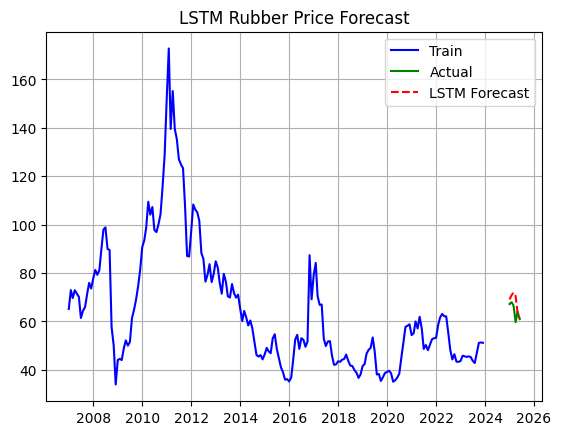

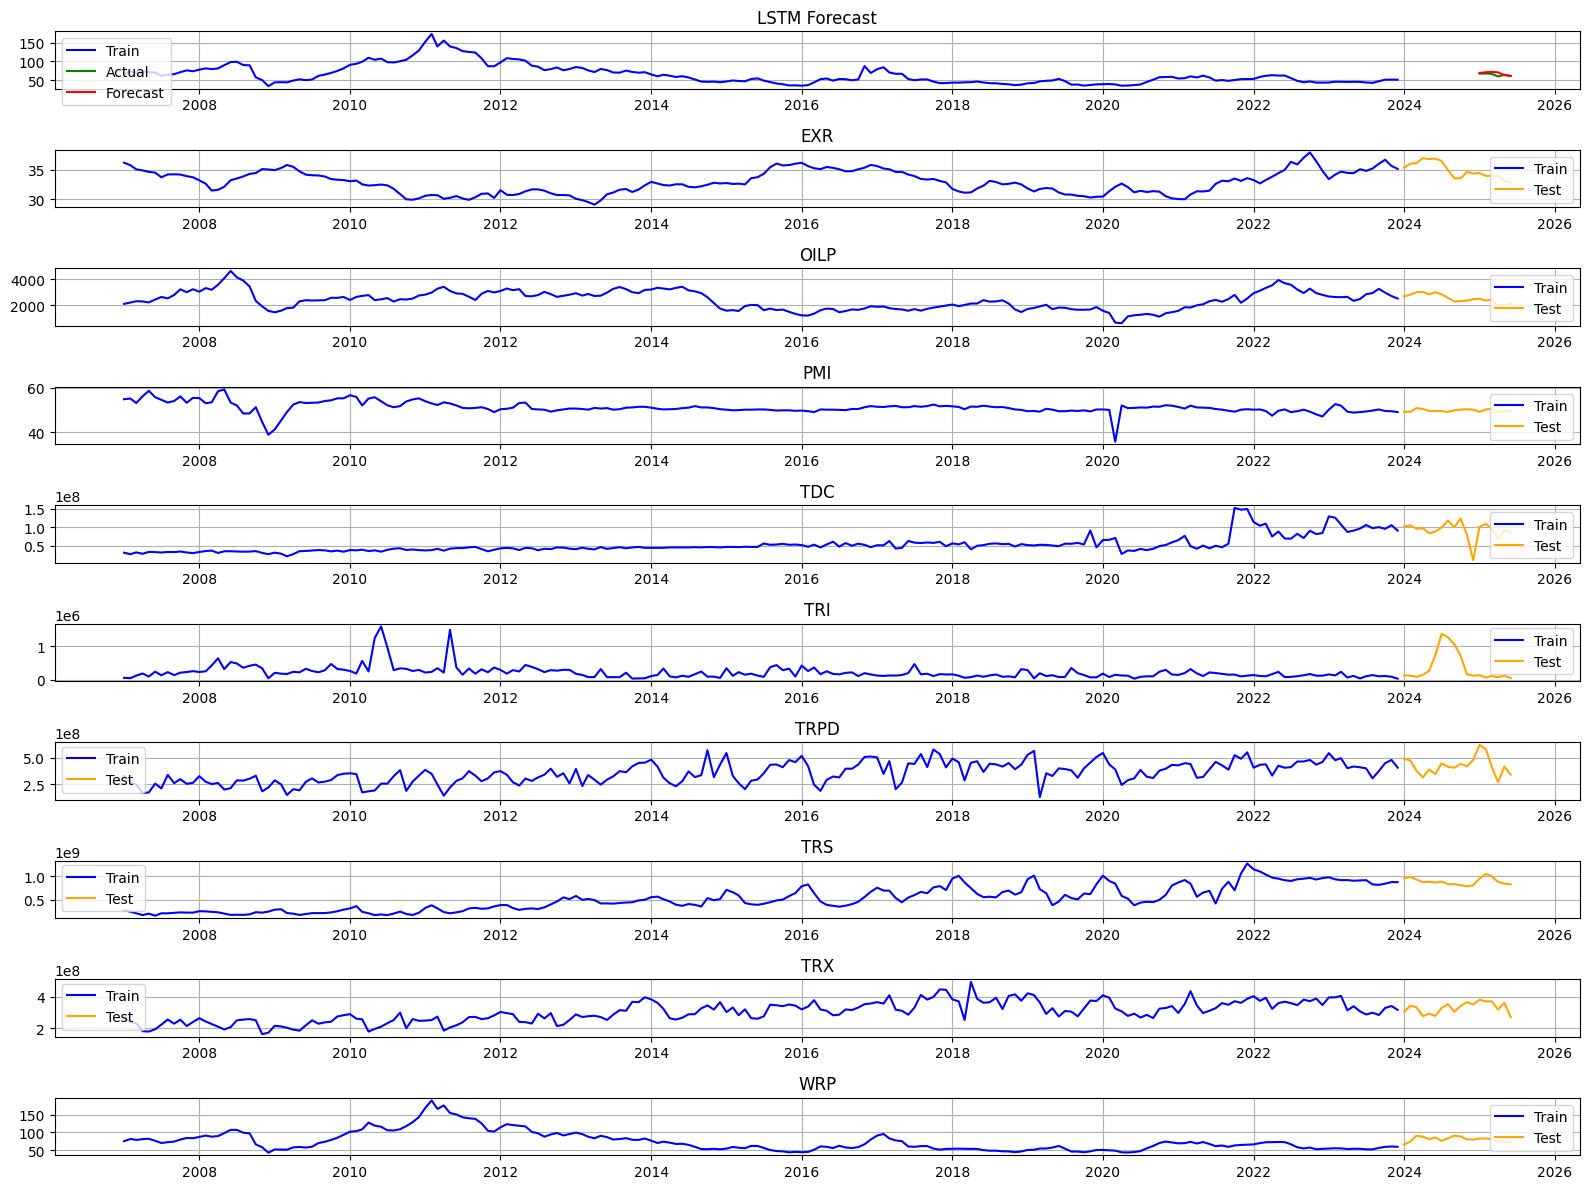

In [ ]:
'''
## plt.figure(figsize=(14,7))
plt.plot(train_data.index, train_data['TRP'], label='Train', color='blue')
plt.plot(test_data.index[WINDOW:], actual_after, label='Actual', color='green')
plt.plot(test_data.index[WINDOW:], pred_after, label='LSTM Forecast', color='red', linestyle='--')
plt.title("LSTM Rubber Price Forecast")
plt.grid(True)
plt.legend()
plt.show()

fig, axes = plt.subplots(len(external_factors)+1, 1, figsize=(16,12))


axes[0].plot(train_data.index, train_data['TRP'], label='Train', color='blue')
axes[0].plot(test_data.index[WINDOW:], actual_after, color='green', label='Actual')
axes[0].plot(test_data.index[WINDOW:], pred_after, color='red', label='Forecast')
axes[0].legend()
axes[0].set_title("LSTM Forecast")
axes[0].grid(True)

for i, fac in enumerate(external_factors):
    ax = axes[i+1]
    ax.plot(train_data.index, train_data[fac], color='blue', label='Train')
    ax.plot(test_data.index, test_data[fac], color='orange', label='Test')
    ax.set_title(fac)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()'''


In [14]:
def compute_score(rmse, mape, mean_trp, w_rmse=0.5, w_mape=0.5):
    """
    Unified Score 0–100 จาก RMSE และ MAPE
    """
    nrmse = rmse / mean_trp        # Normalize ด้วย mean ของ TRP
    mape_norm = mape / 100.0
    score = 100 * (1 - (w_rmse*nrmse + w_mape*mape_norm))
    return max(0, min(100, score))

score_before = compute_score(rmse_before, mape_before, mean_trp)
score_after  = compute_score(rmse_after,  mape_after,  mean_trp)

summary_df = pd.DataFrame({
    "Model": ["Before (Baseline Ridge)", "After (Optuna Ridge)"],
    "RMSE": [rmse_before, rmse_after],
    "MAPE (%)": [mape_before, mape_after],
    "Score (0-100)": [score_before, score_after]
})

print("=== COMPARISON: BEFORE vs AFTER (LSTM) ===")
print(summary_df.to_string(index=False))


=== COMPARISON: BEFORE vs AFTER (LSTM) ===
                  Model     RMSE  MAPE (%)  Score (0-100)
Before (Baseline Ridge) 9.428791 13.483126      85.957996
   After (Optuna Ridge) 5.132526  5.778474      93.136796


PCA + LSTM

In [15]:
print("\nPCA + LSTM")

approach_pca_lstm = []

scaler2 = StandardScaler()
train_scaled2 = scaler2.fit_transform(train_exog)
test_scaled2  = scaler2.transform(test_exog)

def seq_lstm(data, win=12):
    X, y = [], []
    for i in range(len(data)-win):
        X.append(data[i:i+win,:])
        y.append(data[i+win,0])
    return np.array(X), np.array(y)


for n_comp in range(2,10):

    pca = PCA(n_components=n_comp)
    train_pca = pca.fit_transform(train_scaled2)
    test_pca  = pca.transform(test_scaled2)

    explained = pca.explained_variance_ratio_.sum()

    #full matrix TRP + PCs
    train_full = np.concatenate([train_data[['TRP']].values, train_pca], axis=1)
    test_full  = np.concatenate([test_data[['TRP']].values, test_pca], axis=1)

    Xtr, ytr = seq_lstm(train_full)
    Xte, yte = seq_lstm(test_full)

    mdl = Sequential([
        LSTM(64, activation='tanh', return_sequences=False,
             input_shape=(12, train_full.shape[1])),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    mdl.compile(optimizer='adam', loss='mse')

    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    mdl.fit(
        Xtr, ytr,
        validation_split=0.1,
        epochs=100,
        batch_size=16,
        callbacks=[es],
        verbose=0
    )

    pred_unscaled = mdl.predict(Xte, verbose=0)

    # The model predicts unscaled TRP values, so no inverse transformation is needed.
    pred = pred_unscaled[:,0]

    rmse = np.sqrt(mean_squared_error(yte, pred))
    mape = mean_absolute_percentage_error(yte, pred)*100

    print(f"{n_comp} comp | Var={explained*100:.1f}% | RMSE={rmse:.4f} | MAPE={mape:.2f}%")

    approach_pca_lstm.append({
        "n_components": n_comp,
        "explained_var": explained,
        "RMSE": rmse,
        "MAPE": mape,
        "pred": pred,
        "true": yte
    })

best_pca_lstm = min(approach_pca_lstm, key=lambda x: x["RMSE"])

print("\n===== Best PCA+LSTM ====")
print("Components:", best_pca_lstm["n_components"])
print("Expl.Var :", best_pca_lstm["explained_var"]*100)
print("RMSE     :", best_pca_lstm["RMSE"])
print("MAPE     :", best_pca_lstm["MAPE"])


PCA + LSTM


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2 comp | Var=59.2% | RMSE=4.9647 | MAPE=6.83%


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3 comp | Var=70.4% | RMSE=16.6068 | MAPE=25.14%


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4 comp | Var=79.5% | RMSE=14.1625 | MAPE=21.26%


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5 comp | Var=88.2% | RMSE=17.1185 | MAPE=25.96%


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6 comp | Var=92.8% | RMSE=14.4957 | MAPE=21.79%


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7 comp | Var=96.2% | RMSE=18.0627 | MAPE=27.45%


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8 comp | Var=98.5% | RMSE=4.6350 | MAPE=5.47%


c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9 comp | Var=100.0% | RMSE=4.6427 | MAPE=5.68%

===== Best PCA+LSTM ====
Components: 8
Expl.Var : 98.54583940605276
RMSE     : 4.635007088828929
MAPE     : 5.46781988125068


Data Visualization

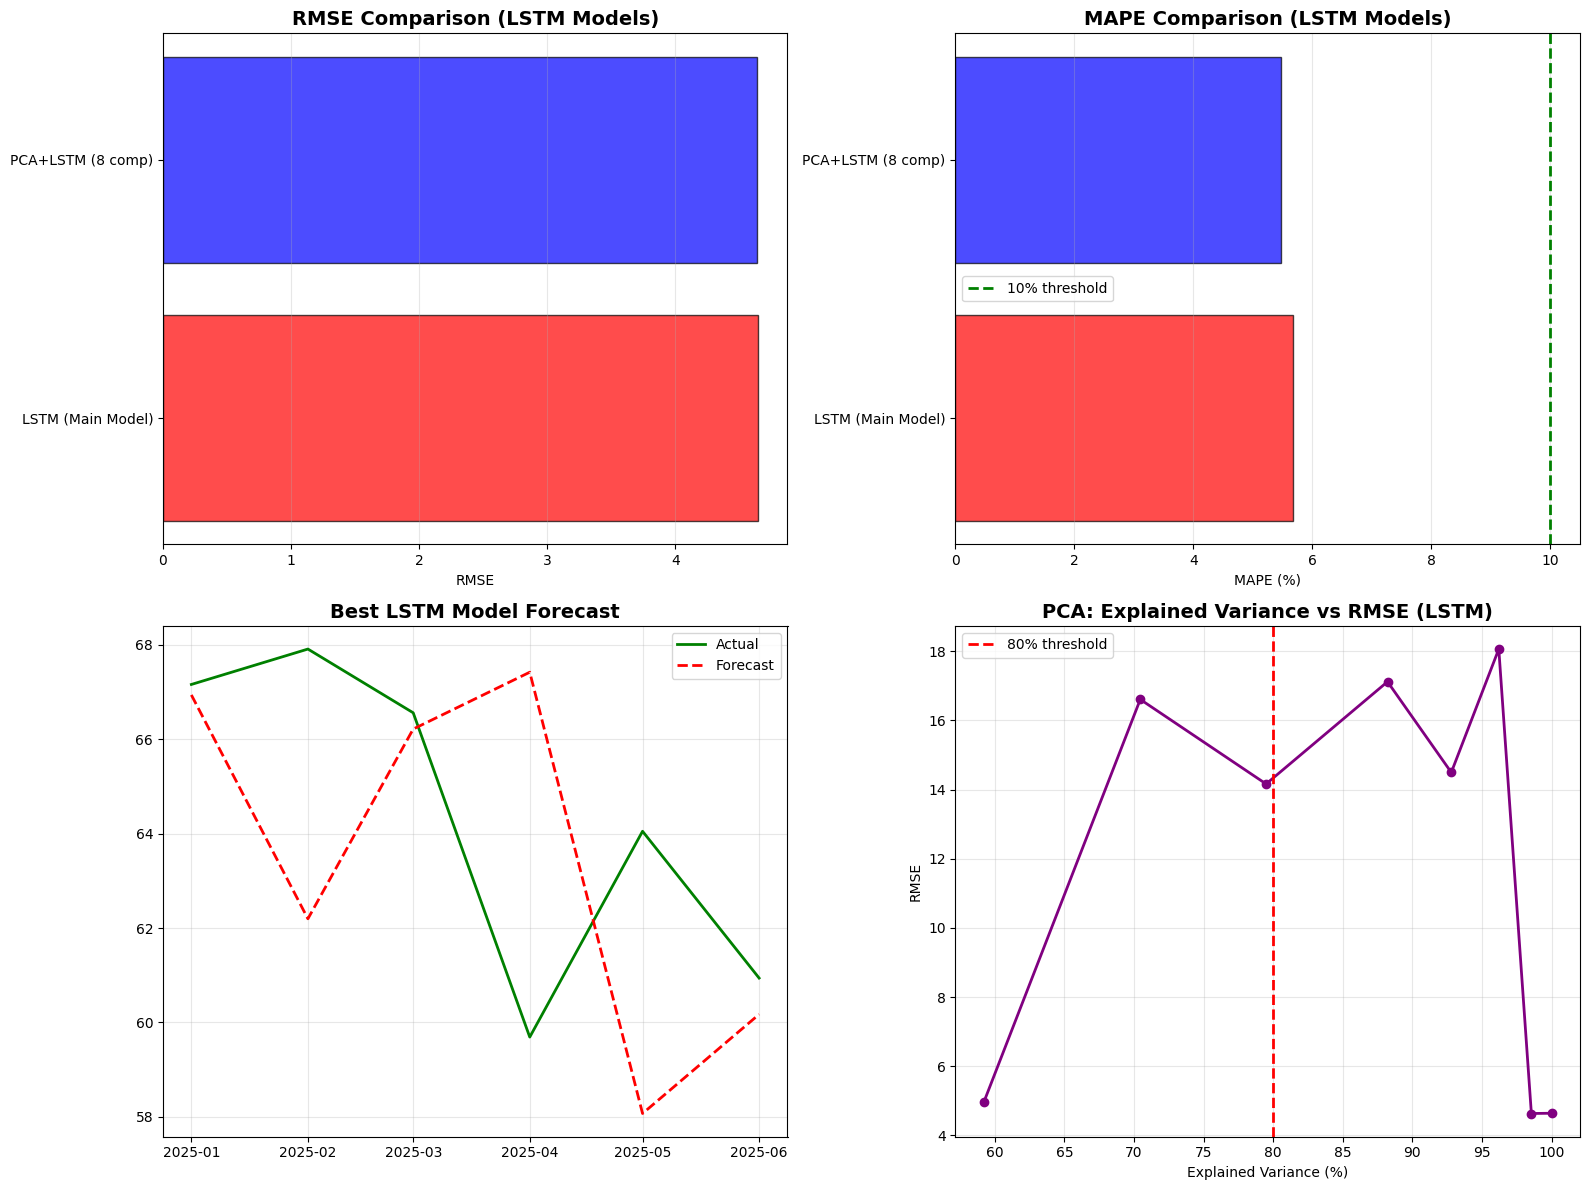

In [16]:
import matplotlib.pyplot as plt

#เทียบเฉพาะ LSTM Main + PCA+LSTM
all_approaches = [
    {
        "Method": "LSTM (Main Model)",
        "RMSE": rmse,
        "MAPE": mape
    },
    {
        "Method": f"PCA+LSTM ({best_pca_lstm['n_components']} comp)",
        "RMSE": best_pca_lstm['RMSE'],
        "MAPE": best_pca_lstm['MAPE']
    }
]

methods = [a["Method"] for a in all_approaches]
rmse_vals = [a["RMSE"] for a in all_approaches]
mape_vals = [a["MAPE"] for a in all_approaches]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

#RMSE Comparison
ax = axes[0, 0]
ax.barh(methods, rmse_vals, color=['red', 'blue'], alpha=0.7, edgecolor='black')
ax.set_title("RMSE Comparison (LSTM Models)", fontsize=14, fontweight='bold')
ax.set_xlabel("RMSE")
ax.grid(True, axis='x', alpha=0.3)


#MAPE Comparison
ax = axes[0, 1]
ax.barh(methods, mape_vals, color=['red', 'blue'], alpha=0.7, edgecolor='black')
ax.axvline(x=10, color='green', linestyle='--', linewidth=2, label='10% threshold')
ax.set_title("MAPE Comparison (LSTM Models)", fontsize=14, fontweight='bold')
ax.set_xlabel("MAPE (%)")
ax.legend()
ax.grid(True, axis='x', alpha=0.3)

#Best Model Forecast
best_overall = (
    best_pca_lstm
    if best_pca_lstm["RMSE"] < rmse
    else {"pred": pred, "true": actual}
)

ax = axes[1, 0]
#กรณีเป็น PCA+LSTM
if "true" in best_overall:
    ax.plot(
        test_data.index[WINDOW:],
        best_overall["true"],
        label="Actual",
        color="green",
        linewidth=2
    )
    ax.plot(
        test_data.index[WINDOW:],
        best_overall["pred"],
        label="Forecast",
        color="red",
        linestyle="--",
        linewidth=2
    )
else:
    #ถ้าเป็น main LSTM
    ax.plot(
        test_data.index[WINDOW:], actual, label='Actual', color='green', linewidth=2)
    ax.plot(
        test_data.index[WINDOW:], pred, label='Forecast', color='red', linestyle='--', linewidth=2)

ax.set_title("Best LSTM Model Forecast", fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

#PCA vs RMSE Curve
ax = axes[1, 1]
exp_vars = [r['explained_var']*100 for r in approach_pca_lstm]
rmse_vals_pca = [r['RMSE'] for r in approach_pca_lstm]

ax.plot(exp_vars, rmse_vals_pca, marker='o', color='purple', linewidth=2)
ax.axvline(x=80, linestyle='--', color='red', linewidth=2, label='80% threshold')

ax.set_xlabel("Explained Variance (%)")
ax.set_ylabel("RMSE")
ax.set_title("PCA: Explained Variance vs RMSE (LSTM)", fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

In [17]:
data = {
    'Model': ['Baseline (LSTM)', 'Optuna LSTM'],
    'RMSE': [rmse_before, rmse_after],
    'MAPE': [mape_before/100, mape_after/100],
    'ACCURACY': [score_before/100, score_after/100]
}

df_comparison = pd.DataFrame(data)

df_comparison['MAPE (%)'] = (df_comparison['MAPE'] * 100).map('{:.2f}%'.format)
df_comparison['ACCURACY (%)'] = (df_comparison['ACCURACY'] * 100).map('{:.2f}%'.format)

df_display = df_comparison[['Model', 'RMSE', 'MAPE (%)', 'ACCURACY (%)']]

print("Performance Comparison (LSTM)\n")
print(df_display.to_string(index=True, col_space=15))

Performance Comparison (LSTM)

                           Model            RMSE        MAPE (%)    ACCURACY (%)
0                Baseline (LSTM)        9.428791          13.48%          85.96%
1                    Optuna LSTM        5.132526           5.78%          93.14%
